In [1]:
import numpy as np
import pandas as pd
import os

import re
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 data/69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 data/Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 data/Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 data/biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 data/bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 data/biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 data/cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 data/economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 data/internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 data/iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 data/kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  20M Jan 15 18:18 data/kultura.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 

In [3]:
name_dataset = 'naula.i.tehn'

### load data

In [4]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(54608, 7)
CPU times: user 6.42 s, sys: 103 ms, total: 6.52 s
Wall time: 6.54 s


In [5]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/msie/,NaN,Мир,Обнаружена очередная дыра в MSIE 5.0,28 сентября обнаружилась очередная брешь в защ...,Наука и техника
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/nasa/,NaN,Мир,Межпланетная станция сгорела из-за ошибки прог...,Межпланетная станция Mars Climate Orbiter стои...,Наука и техника


### preprocess

* get dates

In [7]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

CPU times: user 172 ms, sys: 0 ns, total: 172 ms
Wall time: 171 ms


* clean text

In [9]:
import preprocessing_tools as pr

In [10]:
%%time
df.text = df.text.apply(pr.clean_text)

CPU times: user 8.93 s, sys: 47.3 ms, total: 8.98 s
Wall time: 8.98 s


In [11]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/msie/,NaN,Мир,Обнаружена очередная дыра в MSIE 5.0,сентября обнаружилась очередная брешь в защите...,Наука и техника,"[(1999, 10, 01)]",1999,10
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/nasa/,NaN,Мир,Межпланетная станция сгорела из-за ошибки прог...,межпланетная станция mars climate orbiter стои...,Наука и техника,"[(1999, 10, 01)]",1999,10


* cleanedNames

In [12]:
from cleanedNames import KeyProc
cn = KeyProc()

In [13]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

CPU times: user 1min 30s, sys: 309 µs, total: 1min 30s
Wall time: 1min 30s


* lemmatization

In [14]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

CPU times: user 2min 20s, sys: 183 ms, total: 2min 20s
Wall time: 2min 20s


* add docID

In [15]:
df['docID'] = list(range(df.shape[0]))

In [16]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,1999,10,"[сентябрь, обнаружиться, очередной, брешь, защ..."
1,1,1999,10,"[межпланетный, станция, mars, climate, orbiter..."


In [17]:
print(df.shape)
df.isnull().sum()

(54608, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [18]:
df.year.min()

1999

## model

* prepare

In [19]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 646 ms, sys: 108 ms, total: 754 ms
Wall time: 753 ms


In [20]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [21]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

create folder...

artm.BatchVectorizer(data_path="data/batches/naula.i.tehn", num_batches=55)
CPU times: user 28.1 s, sys: 656 ms, total: 28.7 s
Wall time: 5.82 s


In [22]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [23]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=1907b594-b044-4c11-839b-19d37ca74745, num_entries=29294)

In [24]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [25]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

for i in range(2,20+1,1):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

    # regularizers
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)
    model_list.append(model)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)
    
newTime = time.now() #

#topic 2.........
	SparsityThetaScore: 0.24033108353614807
	SparsityPhiScore: 0.26085546612739563
	PerplexityScore: 4865.236328125
	time: 0:00:46.514783
#topic 3.........
	SparsityThetaScore: 0.3256482481956482
	SparsityPhiScore: 0.4306228756904602
	PerplexityScore: 4462.1259765625
	time: 0:00:49.196098
#topic 4.........
	SparsityThetaScore: 0.4195447564125061
	SparsityPhiScore: 0.5099081993103027
	PerplexityScore: 3877.2099609375
	time: 0:00:50.668782
#topic 5.........
	SparsityThetaScore: 0.5426530838012695
	SparsityPhiScore: 0.5420085787773132
	PerplexityScore: 3408.09716796875
	time: 0:00:51.578791
#topic 6.........
	SparsityThetaScore: 0.5798112750053406
	SparsityPhiScore: 0.5897282958030701
	PerplexityScore: 3201.00244140625
	time: 0:00:53.381560
#topic 7.........
	SparsityThetaScore: 0.6096464395523071
	SparsityPhiScore: 0.6231651306152344
	PerplexityScore: 3065.321044921875
	time: 0:00:54.533829
#topic 8.........
	SparsityThetaScore: 0.6450725793838501
	SparsityPhiScore: 0.6497

In [31]:
#model_list

Text(0.5, 1.0, 'SparsityPhiScore')

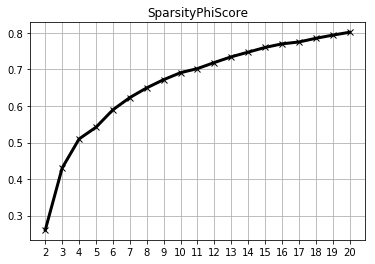

In [26]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [27]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

[0.2, 0.4, 0.5, 0.6, 0.7, 0.8]

In [28]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

{0.2: 1, 0.4: 1, 0.5: 3, 0.6: 4, 0.7: 9, 0.8: 1}

Text(0.5, 1.0, 'SparsityThetaScore')

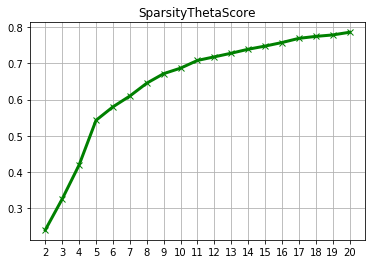

In [29]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [30]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

[0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [31]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

{0.2: 1, 0.3: 1, 0.4: 1, 0.5: 2, 0.6: 4, 0.7: 10}

Text(0.5, 1.0, 'PerplexityScore')

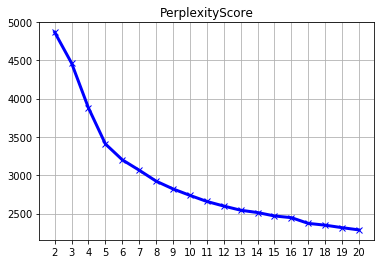

In [32]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [33]:
perplexity

[4865.236328125,
 4462.1259765625,
 3877.2099609375,
 3408.09716796875,
 3201.00244140625,
 3065.321044921875,
 2922.6142578125,
 2821.301025390625,
 2737.08642578125,
 2657.63525390625,
 2597.9296875,
 2543.325927734375,
 2512.9716796875,
 2468.44775390625,
 2446.339111328125,
 2371.583740234375,
 2348.205322265625,
 2315.755615234375,
 2286.4716796875]

### select the best model

In [55]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

d_sphi:   {0.2: 1, 0.4: 1, 0.5: 3, 0.6: 4, 0.7: 9, 0.8: 1}
d_stheta: {0.2: 1, 0.3: 1, 0.4: 1, 0.5: 2, 0.6: 4, 0.7: 10}


In [56]:
select_topics = 19 # u should choose number of topic

best_model = model_list[select_topics-2]
print(best_model.num_topics)

19


### print top words for each topics

In [57]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['клетка' 'ген' 'днк' 'организм' 'вещество' 'заболевание' 'бактерия'
 'геном' 'вирус' 'белок']
topic_1: ['apple' 'windows' 'microsoft' 'компьютер' 'iphone' 'процессор'
 'операционный' 'смартфон' 'рынок' 'intel']
topic_2: ['смартфон' 'экран' 'модель' 'samsung' 'телефон' 'гигабайт' 'камера'
 'цена' 'память' 'дисплей']
topic_3: ['консоль' 'студия' 'xbox' 'of' 'серия' 'релиз' 'playstation' 'игровой'
 'издательство' 'геймер']
topic_4: ['машина' 'испытание' 'беспилотник' 'вертолёт' 'беспилотный' 'двигатель'
 'военный' 'метр' 'вооружение' 'час']
topic_5: ['самолёт' 'истребитель' 'ввс' 'индия' 'поставка' 'контракт' 'вооружение'
 'военный' 'оборона' 'индийский']
topic_6: ['частица' 'энергия' 'физика' 'квантовый' 'магнитный' 'теория' 'атом'
 'статья' 'излучение' 'состояние']
topic_7: ['мозг' 'ребёнок' 'женщина' 'мужчина' 'эксперимент' 'жизнь' 'вывод'
 'возраст' 'участник' 'поведение']
topic_8: ['научный' 'наука' 'премия' 'институт' 'область' 'участие' 'фонд'
 'конкурс' 'хороший' 'директ

### get topics-docs matrix

shape theta: (19, 54608)


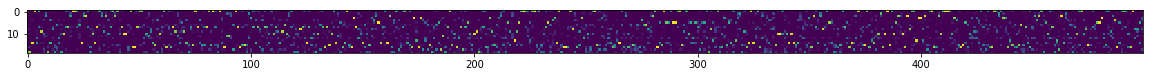

In [58]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [59]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18
26000,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
26001,0.0,0.000000,0.0,0.988249,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.011751,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
26002,0.0,0.208387,0.0,0.334871,0.0,0.0,0.0,0.038127,0.000000,0.0,0.000000,0.418615,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
26003,0.0,0.000000,0.0,0.852582,0.0,0.0,0.0,0.000000,0.076541,0.0,0.000000,0.051074,0.000000,0.0,0.0,0.016228,0.003574,0.0,0.0
26004,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.797473,0.000000,0.065893,0.0,0.0,0.000000,0.136634,0.0,0.0


## DataViz

In [63]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18
0,0,1999,10,0.000000,0.141658,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.607682,0.239014,0.000000,0.000000,0.000000,0.000000,0.0,0.011647
1,1,1999,10,0.000000,0.000000,0.0,0.0,0.040125,0.0,0.025096,...,0.0,0.308955,0.097090,0.034172,0.000000,0.000000,0.000000,0.383772,0.0,0.110790
2,2,1999,10,0.000000,0.438692,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.561308,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,3,1999,10,0.009301,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.051587,0.000000,0.566148,0.107391,0.0,0.223364
4,4,1999,10,0.000000,0.000000,0.0,0.0,0.069671,0.0,0.000000,...,0.0,0.050243,0.000000,0.223585,0.000000,0.500638,0.000000,0.000000,0.0,0.155862


In [64]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (228, 19)


topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  \
year month                                                               
1999 8      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
     9      2.361070  2.165766  0.088578  0.111021  0.247456  0.697292   
     10     2.312212  2.821992  0.938274  0.138780  0.586331  0.300596   
     11     0.635744  5.803607  0.545815  0.099080  0.833945  0.284603   
     12     1.546199  4.225889  0.561820  0.125677  0.162535  0.876164   

             topic_6   topic_7   topic_8   topic_9  topic_10  topic_11  \
year month                                                               
1999 8      0.000000  0.045525  0.014244  0.062028  0.502958  0.000000   
     9      0.059110  1.116163  2.701233  1.069942  6.433418  1.426954   
     10     0.774829  1.621021  3.190050  0.994023  2.877356  3.235147   
     11     0.160687  2.024089  1.722204  0.538815  5.620549  4.976746   
     12     0.196665  2.079142  1.749833  0.968536  7.762601  5.421907   

             topic_12  topic_13  topic_14  topic_15  topic_16  topic_17  \
year month                                                                
1999 8       0.202582  0.000000  0.000000  0.000000  0.000000  0.000000   
     9       5.465328  0.325013  1.880250  1.095283  1.075000  1.244729   
     10      6.311970  0.279411  1.318261  1.273385  1.536036  2.552556   
     11     10.608054  0.774880  3.457625  0.659104  1.339519  1.967619   
     12      7.289620  0.022455  1.178292  0.536882  1.079959  1.842921   

            topic_18  
year month            
1999 8      0.172662  
     9      1.436394  
     10     1.937770  
     11     2.947315  
     12     1.372902

### straightforward matrix heatmap

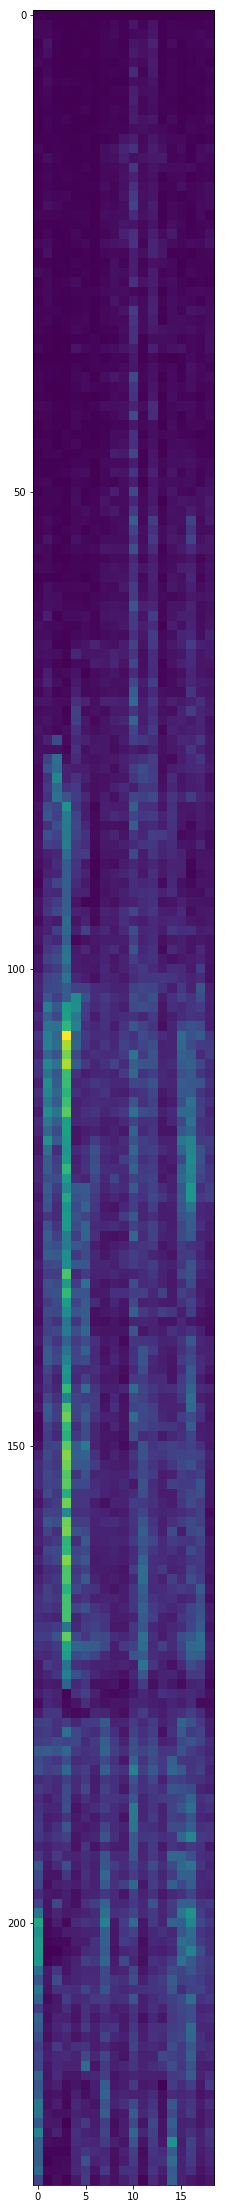

In [65]:
plt.figure(figsize=(10, 40))
plt.imshow(gb[topics])

## pygal

In [66]:
import pygal
from IPython.display import SVG, HTML

In [67]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [ ]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [69]:
line_chart.render_to_file(f"data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg")

## joypy

In [70]:
import joypy # !pip install joypy

In [71]:
print(joined.shape)
joined.head()

(54608, 22)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18
0,0,1999,10,0.000000,0.141658,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.607682,0.239014,0.000000,0.000000,0.000000,0.000000,0.0,0.011647
1,1,1999,10,0.000000,0.000000,0.0,0.0,0.040125,0.0,0.025096,...,0.0,0.308955,0.097090,0.034172,0.000000,0.000000,0.000000,0.383772,0.0,0.110790
2,2,1999,10,0.000000,0.438692,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.561308,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,3,1999,10,0.009301,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.051587,0.000000,0.566148,0.107391,0.0,0.223364
4,4,1999,10,0.000000,0.000000,0.0,0.0,0.069671,0.0,0.000000,...,0.0,0.050243,0.000000,0.223585,0.000000,0.500638,0.000000,0.000000,0.0,0.155862


In [72]:
joined['year_month'] = joined.apply(lambda x: str(int(x.year)) +'-'+ str(int(x.month)) + '-01', axis=1)
joined.reset_index(inplace=True)

joined.head()

,index,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,year_month
0,0,0,1999,10,0.000000,0.141658,0.0,0.0,0.000000,0.0,...,0.000000,0.607682,0.239014,0.000000,0.000000,0.000000,0.000000,0.0,0.011647,1999-10-01
1,1,1,1999,10,0.000000,0.000000,0.0,0.0,0.040125,0.0,...,0.308955,0.097090,0.034172,0.000000,0.000000,0.000000,0.383772,0.0,0.110790,1999-10-01
2,2,2,1999,10,0.000000,0.438692,0.0,0.0,0.000000,0.0,...,0.000000,0.561308,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1999-10-01
3,3,3,1999,10,0.009301,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.051587,0.000000,0.566148,0.107391,0.0,0.223364,1999-10-01
4,4,4,1999,10,0.000000,0.000000,0.0,0.0,0.069671,0.0,...,0.050243,0.000000,0.223585,0.000000,0.500638,0.000000,0.000000,0.0,0.155862,1999-10-01


In [73]:
joined_melt = joined.melt('year_month', var_name='topic', value_name='text')
print(joined_melt.shape)
joined_melt.head()

(1255984, 3)


,year_month,topic,text
0,1999-10-01,index,0.0
1,1999-10-01,index,1.0
2,1999-10-01,index,2.0
3,1999-10-01,index,3.0
4,1999-10-01,index,4.0


In [74]:
# select only topic_*
joined_melt_new = joined_melt[(joined_melt.topic!='docID') & (joined_melt.topic!='index')
                              & (joined_melt.topic!='year') & (joined_melt.topic!='month')]
print(joined_melt_new.shape)
joined_melt_new.topic.value_counts()

(1037552, 3)


topic_18    54608
topic_6     54608
topic_2     54608
topic_0     54608
topic_15    54608
topic_10    54608
topic_14    54608
topic_12    54608
topic_9     54608
topic_13    54608
topic_1     54608
topic_17    54608
topic_8     54608
topic_7     54608
topic_4     54608
topic_3     54608
topic_5     54608
topic_16    54608
topic_11    54608
Name: topic, dtype: int64

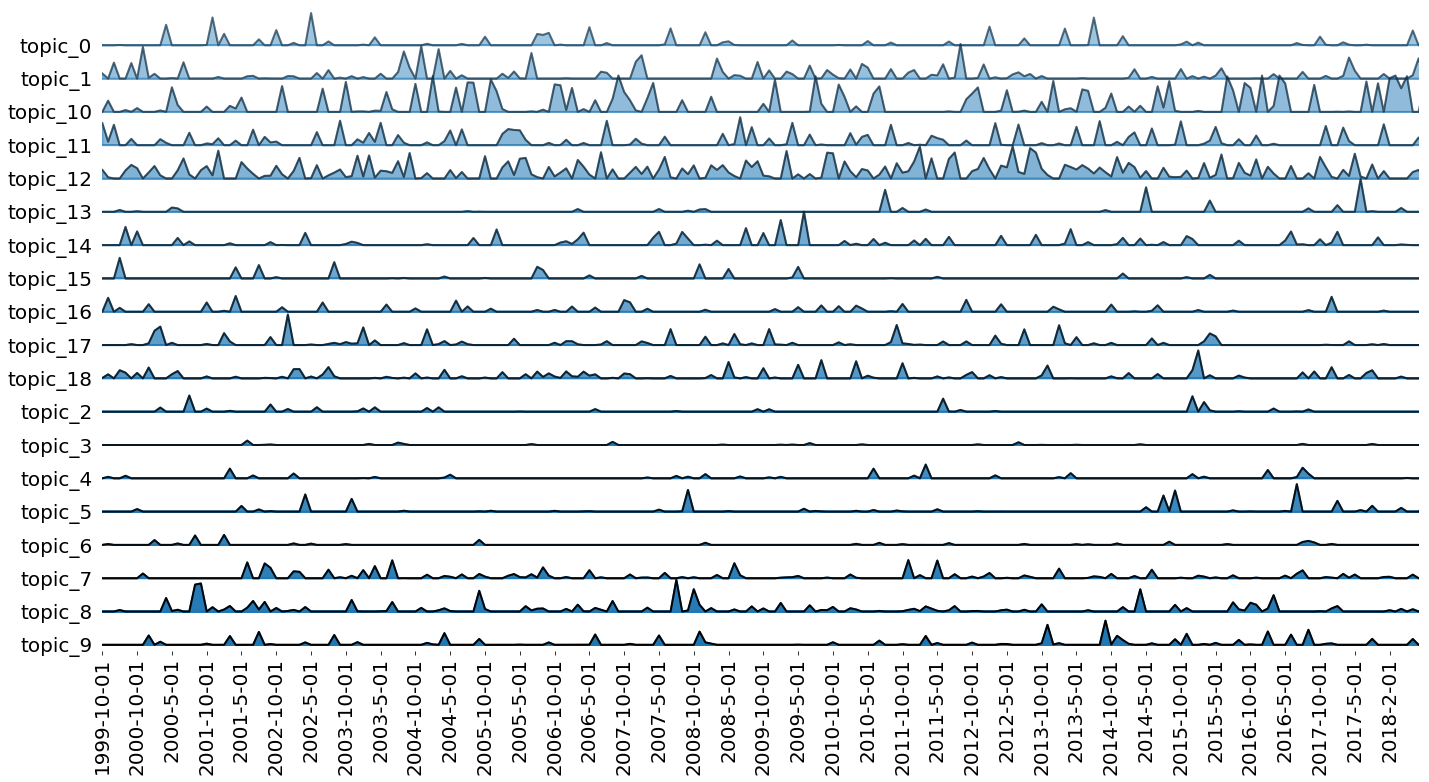

In [75]:
labels = sorted(joined_melt_new['year_month'].unique())

fig, axes = joypy.joyplot(joined_melt_new, by='topic', column='text', figsize=(20, 10),xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True, linecolor="k", linewidth=2,
                          kind='values', fade=True, xrot=90, x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [80]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")